# Ibis demo

The purpose of this notebook is to show how easy analytics in Python can be.

## Setup

TODO: this section

In short, `gh repo clone ibis-project/ibis && cd ibis && pip install -e .`.

Pip install other packages used below.

## Get data platform info

Reuse the dbt profile. dbt should make this + the below connection easy.

In [32]:
import yaml

# replace as needed
PROFILE_PATH = "/root/.dbt/profiles.yml"
PROFILE_NAME = "snowflake"
PROFILE_OUTPUT = "dev"

# read in dbt profile
with open(PROFILE_PATH, "r") as f:
    profiles = yaml.safe_load(f)
    profile = profiles[PROFILE_NAME]["outputs"][PROFILE_OUTPUT]

# build connection parameters from profile
conn_params = {
    "account": profile["account"],
    "user": profile["user"],
    "role": profile["role"],
    "warehouse": profile["warehouse"],
    "database": profile["database"],
    "schema": profile["schema"],
    "authenticator": profile["authenticator"],
}

## Start with Ibis

Import.

In [33]:
import ibis

## Create a client object

dbt should make this easier.

It took me longer than I'd like to admit to figure out the specifics of the string needed.

In [34]:
s = ibis.connect(
    f"snowflake://{conn_params['user']}:_@{conn_params['account']}/{conn_params['database']}/{conn_params['schema']}?warehouse={conn_params['warehouse']}&role={conn_params['role']}&authenticator={conn_params['authenticator']}",
)

Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...


check for available tables

In [35]:
[x for x in s.list_tables() if "orders" in x]

['int_orders', 'orders', 'stg_orders']

there's a method for that

In [36]:
s.list_tables(like=".*orders.*")

['int_orders', 'orders', 'stg_orders']

In [37]:
s.list_tables(like=".*_py.*")

['cluster_py',
 'describe_py',
 'forecast_py',
 'forecast_score_py',
 'forecast_train_py',
 'fuzz_py',
 'pivot_py',
 'stg_test_py',
 'test_py',
 'unfuzz_py',
 'unfuzzed_py']

In [38]:
s.list_tables(like="stg_.*")

['stg_customers',
 'stg_locations',
 'stg_order_items',
 'stg_orders',
 'stg_products',
 'stg_supplies',
 'stg_test_py']

## Analytics

Let's rewrite some SQL in Python for demonstration purposes -- my favorite! (this is becoming my life, please help me)

The orders mart:

```sql

with

orders as (

    select * from {{ ref('stg_orders') }}

),

order_items as (

    select * from {{ ref('stg_order_items') }}

),

products as (

    select * from {{ ref('stg_products') }}

),

locations as (

    select * from {{ ref('stg_locations') }}

),

supplies as (

    select * from {{ ref('stg_supplies') }}

),

order_items_summary as (

    select

        order_id,

        sum(products.is_food_item) as count_food_items,
        sum(products.is_drink_item) as count_drink_items,
        count(*) as count_items,

        sum(case when products.is_food_item = 1 then product_price else 0 end) as subtotal_drink_items,
        sum(case when products.is_drink_item = 1 then product_price else 0 end) as subtotal_food_items,
        sum(product_price) as subtotal

    from order_items
    join products using (product_id)

    group by 1

),

order_supplies_summary as (

    select

        order_id,

        sum(supplies.supply_cost) as order_cost

    from order_items
    join supplies using (product_id)

    group by 1

),

joined as (

    select

        orders.*,

        order_items_summary.count_food_items,
        order_items_summary.count_drink_items,
        order_items_summary.count_items,

        order_items_summary.subtotal_drink_items,
        order_items_summary.subtotal_food_items,
        order_items_summary.subtotal,

        order_supplies_summary.order_cost,

        -- rank this order for the customer
        row_number() over (
            partition by orders.customer_id
            order by orders.ordered_at
        ) as customer_order_index,

        locations.location_name

    from orders
    join order_items_summary using (order_id)
    join order_supplies_summary using (order_id)
    join locations using (location_id)

),

final as (

    select 
        
        *,
        customer_order_index = 1 as is_first_order,
        count_food_items > 0 as is_food_order,
        count_drink_items > 0 as is_drink_order

    from joined

)

select * from final

```

The customers mart:

```sql
with

customers as (

    select * from {{ ref('stg_customers') }}

),

orders as (

    select * from {{ ref('orders') }}

),

order_summary as (

    select
        customer_id,

        count(*) as count_lifetime_orders,
        count(*) > 1 as is_repeat_buyer,
        min(ordered_at) as first_ordered_at,
        max(ordered_at) as last_ordered_at,

        sum(subtotal) as lifetime_spend_pretax,
        sum(order_total) as lifetime_spend

    from orders
    group by 1

),

joined as (

    select
        customers.*,
        order_summary.count_lifetime_orders,
        order_summary.first_ordered_at,
        order_summary.last_ordered_at,
        order_summary.lifetime_spend_pretax,
        order_summary.lifetime_spend,

        case
            when order_summary.is_repeat_buyer then 'returning'
            else 'new'
        end as customer_type

    from customers
    join order_summary using (customer_id)

)

select * from joined
```


In [39]:
stg_orders = s.table("stg_orders")
stg_orders = stg_orders.relabel({col: str(col).lower() for col in stg_orders.columns})
stg_orders.limit(5).execute()

,order_id,location_id,customer_id,order_total,tax_paid,ordered_at
0,d3d0ff03-c478-4495-bda0-5e86a97095d1,fb199829-e587-4d3e-8de0-efc0156c0d48,90bfe313-2191-4c5e-b87f-ae95261f9d73,18.06,1.06,2019-11-29 17:53:00
1,b3431f2e-5ac0-4b79-91e5-448e50230f7e,fb199829-e587-4d3e-8de0-efc0156c0d48,0da08ba9-a93b-41b9-8069-0220a3565810,4.25,0.25,2019-11-29 08:38:00
2,3baf2e72-547a-47d2-8a17-6e475f4dc369,fb199829-e587-4d3e-8de0-efc0156c0d48,fb5057be-92d7-4962-8b92-62f569211fe8,5.31,0.31,2019-11-29 08:14:00
3,537d04a3-6250-416a-a728-f963eff0bf69,fb199829-e587-4d3e-8de0-efc0156c0d48,7dca001f-ea65-4cec-bb0e-eca950aa8832,5.31,0.31,2019-11-29 07:43:00
4,e42569bc-588a-4b87-b6db-dbcb1d7acf8c,fb199829-e587-4d3e-8de0-efc0156c0d48,1a88f733-b6f6-46a1-9328-9594ac879645,5.31,0.31,2019-11-29 09:57:00


In [40]:
stg_order_items = s.table("stg_order_items")
stg_order_items = stg_order_items.relabel(
    {col: str(col).lower() for col in stg_order_items.columns}
)
stg_order_items.limit(5).execute()

,order_item_id,order_id,product_id
0,86d958ee-7533-4fcd-b08a-60079920de42,cf6fb65b-beb0-4236-9d2a-79d40dab0506,JAF-002
1,94e72042-ef2b-40de-91a7-0d5a278662da,58ac7bd3-a41f-4783-8019-e34c5948f714,BEV-005
2,fb088dee-1653-497b-8e81-3e2516c7b272,62c19dd2-2d77-4dc5-9e1e-1339fcfedd0d,BEV-004
3,14cccd44-b016-4cbb-acf3-91f59b6cda35,1cdb4d79-a396-44e7-aeba-f1cb96483d14,BEV-004
4,6f62448c-bda0-4f9b-8529-6d43fedf42a4,3b1f8463-0cff-42a5-ac19-77bf3f3b60a4,BEV-003


In [41]:
stg_products = s.table("stg_products")
stg_products = stg_products.relabel(
    {col: str(col).lower() for col in stg_products.columns}
)
stg_products.execute()

,product_id,product_name,product_type,product_description,product_price,is_food_item,is_drink_item
0,JAF-001,nutellaphone who dis?,jaffle,nutella and banana jaffle,11.0,1,0
1,JAF-002,doctor stew,jaffle,house-made beef stew jaffle,11.0,1,0
2,JAF-003,the krautback,jaffle,lamb and pork bratwurst with house-pickled cab...,12.0,1,0
3,JAF-004,flame impala,jaffle,pulled pork and pineapple al pastor marinated ...,14.0,1,0
4,JAF-005,mel-bun,jaffle,"melon and minced beef bao, in a jaffle, savory...",12.0,1,0
5,BEV-001,tangaroo,beverage,mango and tangerine smoothie,6.0,0,1
6,BEV-002,chai and mighty,beverage,oatmilk chai latte with protein boost,5.0,0,1
7,BEV-003,vanilla ice,beverage,iced coffee with house-made french vanilla syrup,6.0,0,1
8,BEV-004,for richer or pourover,beverage,daily selection of single estate beans for a d...,7.0,0,1
9,BEV-005,adele-ade,beverage,"a kiwi and lime agua fresca, hello from the ot...",4.0,0,1


In [42]:
stg_locations = s.table("stg_locations")
stg_locations = stg_locations.relabel(
    {col: str(col).lower() for col in stg_locations.columns}
)
stg_locations.execute()

,location_id,location_name,tax_rate,opened_at
0,2018dba7-0d00-46e1-9e49-9a99db25649b,Philadelphia,0.0600,2016-09-01
1,1f52874a-0461-4cfb-9fa7-9e39eab2cfda,Brooklyn,0.0400,2017-03-12
2,fb199829-e587-4d3e-8de0-efc0156c0d48,Chicago,0.0625,2018-04-29
3,eed97b42-081b-4ed8-b5e4-32a45659094d,San Francisco,0.0750,2018-05-09
4,b8d4c6a3-41cd-42aa-857f-3183be9dca08,New Orleans,0.0400,2019-03-10


In [43]:
stg_supplies = s.table("stg_supplies")
stg_supplies = stg_supplies.relabel(
    {col: str(col).lower() for col in stg_supplies.columns}
)
stg_supplies.limit(5).execute()

,supply_uuid,supply_id,product_id,supply_name,supply_cost,is_perishable_supply
0,0c1009250b32f19a8c96b44ba55d3cb3,SUP-001,JAF-001,compostable cutlery - knife,0.07,None
1,df0b5eb60008c8458493b56369126201,SUP-002,JAF-001,cutlery - fork,0.07,None
2,1a9db79a0dffc7f7d9a4d44306cddbd3,SUP-003,JAF-001,serving boat,0.11,None
3,a9ff71f9b28f5ff09ec765c563ebe547,SUP-004,JAF-001,napkin,0.04,None
4,de2daf744eb5b1586ce87485e5d0dc94,SUP-009,JAF-001,bread,0.33,None


In [44]:
count_food_items = stg_products.is_food_item.sum()
count_food_items.execute()

5

In [45]:
count_drink_items = stg_products.is_drink_item.sum()
count_drink_items.execute()

5

In [46]:
count_items = stg_products.product_id.count()
count_items.execute()

10

In [47]:
order_items_summary = (
    stg_order_items.left_join(stg_products, "product_id")
    .group_by("order_id")
    .aggregate(
        count_food_items=count_food_items,
        count_drink_items=count_drink_items,
        count_items=count_items,
    )
)

order_items_summary.limit(5).execute()

,order_id,count_food_items,count_drink_items,count_items
0,a37ad1ea-1b56-42e4-8034-7b0070bccfbb,2,2,4
1,bd9e7655-c05f-4c61-bce2-97d9a9634c63,2,0,2
2,bbd4965e-cdba-4850-af85-a301aad3de50,2,0,2
3,16e9b209-dde9-4b3d-b62d-fbcb4e83298d,0,1,1
4,5ad0fdc2-181b-4356-ba81-bb338dd72b4d,0,1,1


In [48]:
order_items_summary.order_by(ibis.desc("count_items")).limit(100).execute()

,order_id,count_food_items,count_drink_items,count_items
0,ff45e4a2-83e9-4ece-ae9c-da3e53dd791a,5,5,10
1,b515332a-ec39-41ca-ae50-237a9b40978e,5,5,10
2,d5e0df0a-276a-4f64-89b1-c8cd037dbb2c,5,5,10
3,f6b082ff-0ef2-4d50-9b34-5182515fe2fb,5,5,10
4,d68958bf-86f3-4de4-9bee-d673835301f3,5,5,10
...,...,...,...,...
95,04f7be15-bc2e-4513-af42-dd7196e9af9a,5,5,10
96,5a7fc7be-0fde-4656-a5d4-8d06dd1a5a20,5,5,10
97,a9f68090-e595-4770-b475-b1d7d241b069,5,5,10
98,0098b1bc-6e05-4363-96ec-3660440dc026,5,5,10


In [49]:
customers = s.table("customers")
customers = customers.relabel({col: str(col).lower() for col in customers.columns})
customers.limit(5).execute()

,customer_id,customer_name,count_lifetime_orders,first_ordered_at,last_ordered_at,lifetime_spend_pretax,lifetime_spend,customer_type
0,15df7af1-ef13-473f-bbea-deedde94ac32,Samuel Stout,952,2016-09-01 07:08:00,2022-10-07 07:59:00,5528.0,5856.12,returning
1,face746f-5b3a-4299-b3ea-a83c6a3a6712,James Gutierrez,805,2016-09-02 08:08:00,2022-10-05 14:07:00,5093.0,5387.69,returning
2,e4a57063-7fff-4e07-acec-6c255e491a9b,Judy Alvarez,907,2016-09-06 07:38:00,2022-10-07 18:03:00,5343.0,5669.02,returning
3,6338ad00-dbf7-419a-9882-be4926d0deff,Vanessa Howell,586,2016-09-14 12:21:00,2022-10-07 14:17:00,6368.0,6747.49,returning
4,6d28d61c-33c4-4759-85ab-80dcd23e17ec,Alyssa Riddle,288,2016-09-01 16:16:00,2022-10-06 10:37:00,3057.0,3240.47,returning


In [50]:
df = customers.execute(limit=None)

In [51]:
import seaborn as sns

import matplotlib.pyplot as plt

# setup viz defaults
sns.set_theme()
sns.set(rc={"figure.figsize": (10, 8)})
sns.set_style("darkgrid")
plt.style.use(["dark_background"])

<AxesSubplot: xlabel='lifetime_spend', ylabel='Density'>

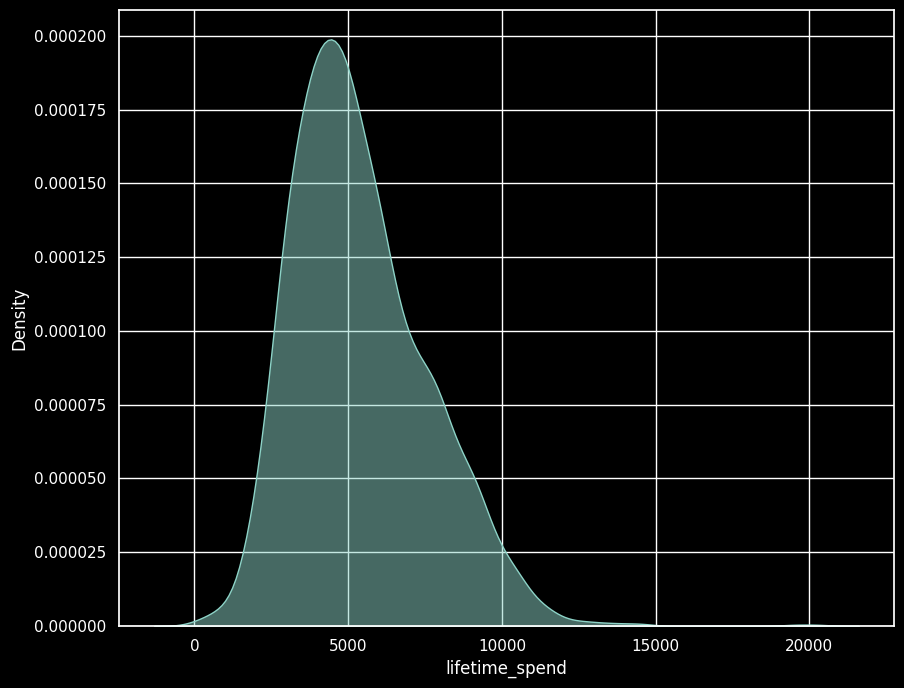

In [52]:
sns.kdeplot(data=df, x="lifetime_spend", fill=True, alpha=0.5)

<AxesSubplot: xlabel='lifetime_spend', ylabel='count_lifetime_orders'>

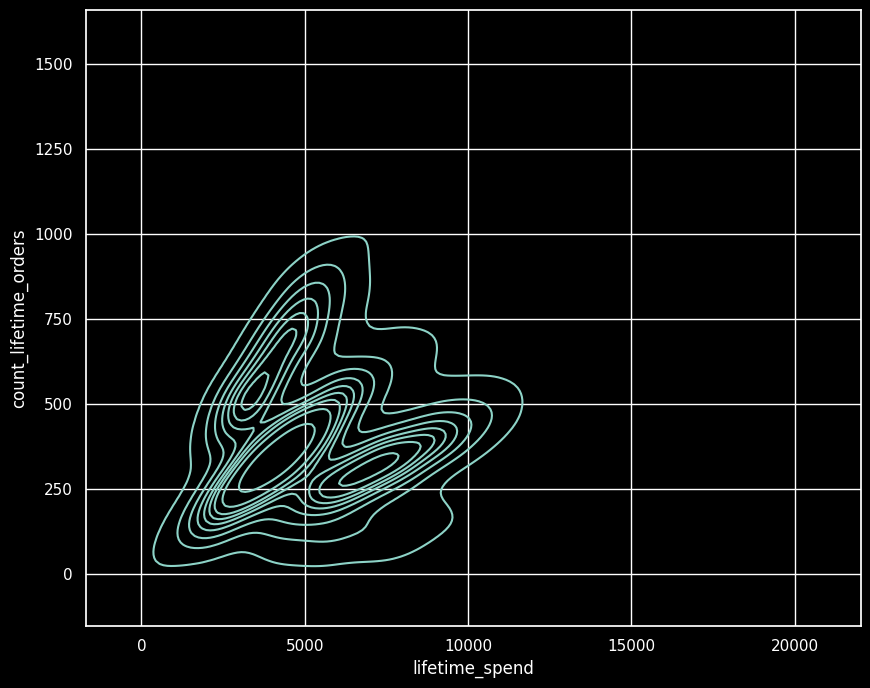

In [53]:
sns.kdeplot(data=df, x="lifetime_spend", y="count_lifetime_orders")

<AxesSubplot: xlabel='lifetime_spend', ylabel='count_lifetime_orders'>

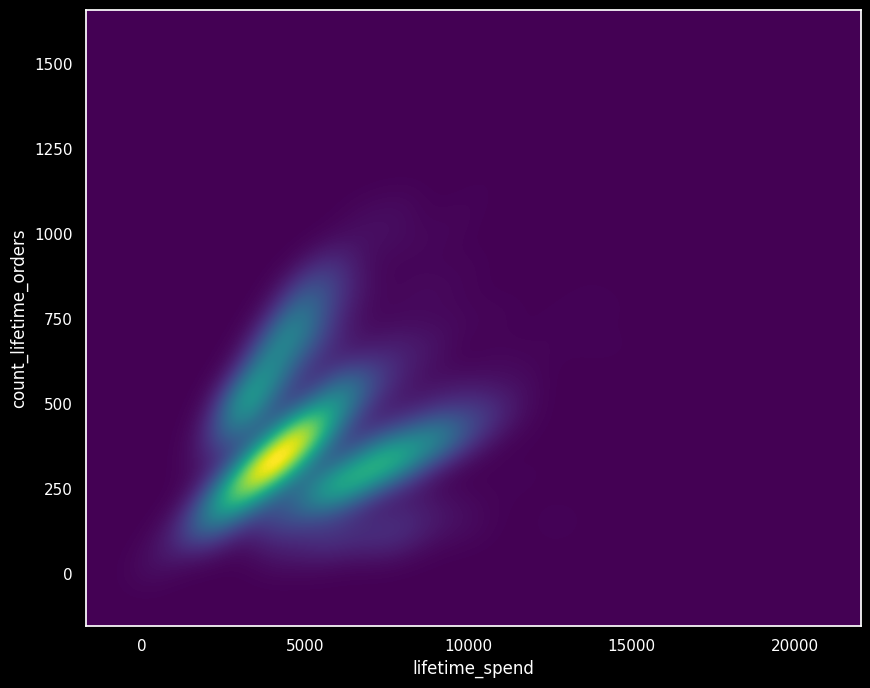

In [54]:
sns.kdeplot(
    data=df,
    x="lifetime_spend",
    y="count_lifetime_orders",
    fill=True,
    thresh=0,
    levels=1000,
    cmap="viridis",
)